# Transfer Learning

### Import Libraries

In [26]:
import numpy as np
import cv2
import time
import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

import tf_keras as tfk                          # needed due to incompatability with tensorflow_hub version
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



### Import Model

In [27]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"      # mobileNetV2
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"        # inceptionNetV3

classifier_model = mobilenet_v2     # choose model that will be used for transfer learning

IMAGE_SHAPE = (224, 224)            # shape of the images that will be used

# instantiate classifier model
classifier = tfk.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [28]:
classifier.summary()    # summary of the model architecture

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [29]:
# import imageNet labels (dataset that mobileNet was originally trained on)
labels_path = tfk.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels[645:655]

array(['matchstick', 'maypole', 'maze', 'measuring cup', 'medicine chest',
       'megalith', 'microphone', 'microwave', 'military uniform',
       'milk can'], dtype='<U30')

## Train with MonkeyPox Dataset

### Hyperparameters

In [30]:
import pathlib

data_root = pathlib.Path("../data/Augmented_Images")

batch_size = 32
img_height = 224
img_width = 224

### Training and Validations datasets

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3192 files belonging to 2 classes.
Using 2554 files for training.
Found 3192 files belonging to 2 classes.
Using 638 files for validation.


In [32]:
class_names = np.array(train_ds.class_names)    # class labels for Monkeypox dataset
print(class_names)

['Monkeypox' 'Others']


### Testing before transfer learning is performed

In [33]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [35]:
result_batch = classifier.predict(train_ds)

predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

80/80 [==============================] - 32s 398ms/step


array(['chiton', 'velvet', 'hog', ..., 'Band Aid', 'hog', 'velvet'],
      dtype='<U30')

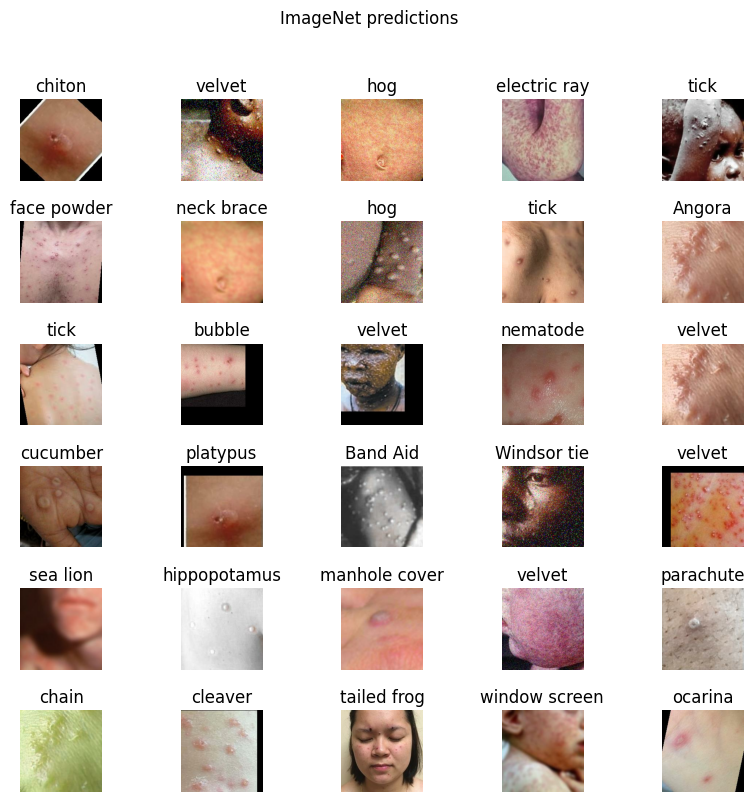

In [36]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Download model without final layer

In [37]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"     # mobileNetV2
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"     # inceptionNetV3

feature_extractor_model = mobilenet_v2      

# instantiate feature extractor layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [38]:
num_classes = len(class_names)

# instantiate model
model = tfk.Sequential([
  feature_extractor_layer,
  tfk.layers.Dense(num_classes)
])

model.summary()   # summary of the model architecture

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Training 

In [39]:
model.compile(
  optimizer=tfk.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [40]:
NUM_EPOCHS = 5

# train model
trained_model = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/5



80/80 [==============================] - 47s 480ms/step - loss: 0.4861 - acc: 0.7725 - val_loss: 0.3890 - val_acc: 0.8260
Epoch 2/5
80/80 [==============================] - 14s 175ms/step - loss: 0.3326 - acc: 0.8610 - val_loss: 0.3225 - val_acc: 0.8636
Epoch 3/5
80/80 [==============================] - 14s 176ms/step - loss: 0.2748 - acc: 0.8923 - val_loss: 0.2849 - val_acc: 0.8887
Epoch 4/5
80/80 [==============================] - 14s 174ms/step - loss: 0.2388 - acc: 0.9064 - val_loss: 0.2608 - val_acc: 0.8966
Epoch 5/5
80/80 [==============================] - 62s 787ms/step - loss: 0.2134 - acc: 0.9190 - val_loss: 0.2438 - val_acc: 0.9013


## Testing

In [41]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 817ms/step
['Others' 'Monkeypox' 'Others' 'Others' 'Monkeypox' 'Others' 'Others'
 'Monkeypox' 'Monkeypox' 'Monkeypox' 'Others' 'Others' 'Monkeypox'
 'Others' 'Monkeypox' 'Monkeypox' 'Others' 'Monkeypox' 'Others' 'Others'
 'Monkeypox' 'Monkeypox' 'Monkeypox' 'Others' 'Monkeypox' 'Monkeypox'
 'Others' 'Others' 'Others' 'Others' 'Monkeypox' 'Others']


### Predictions

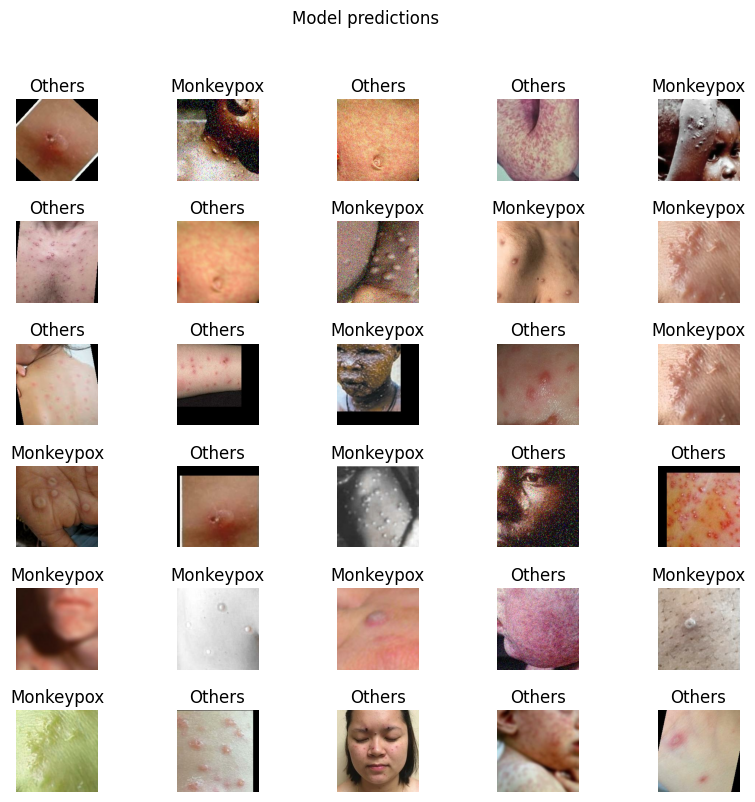

In [42]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Metrics

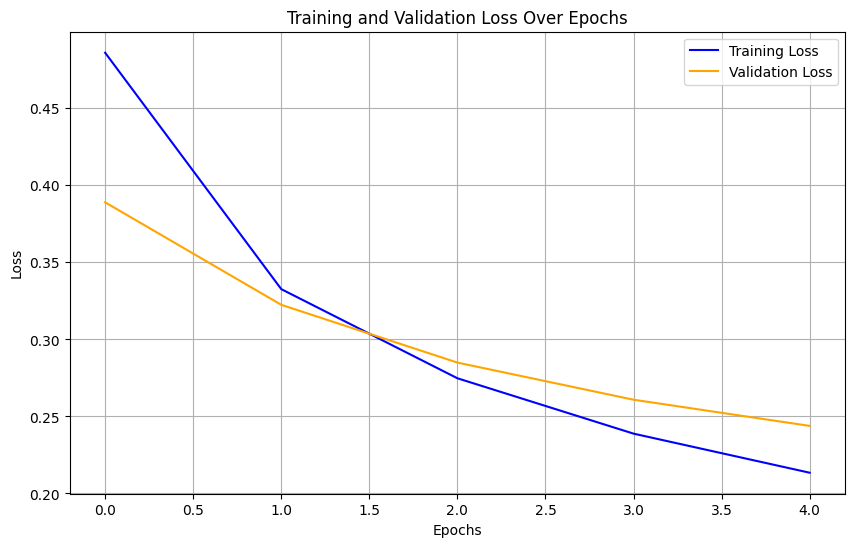

In [50]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(trained_model.history['loss'], label='Training Loss', color='blue')
plt.plot(trained_model.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

20/20 [==============================] - 3s 139ms/step


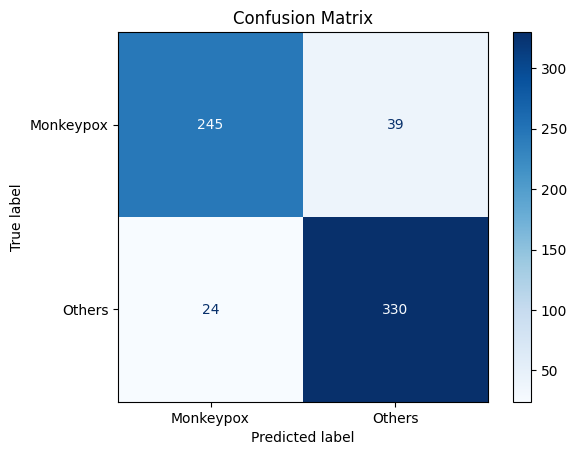

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the entire validation set
val_predictions = model.predict(val_ds)
val_predicted_ids = np.argmax(val_predictions, axis=-1)

# Get the true labels from the validation set
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, val_predicted_ids)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.9013
Sensitivity (Recall): 0.8974
Specificity: 0.8869
F1-Score: 0.8995

Classification Report:
               precision    recall  f1-score   support

   Monkeypox     0.9108    0.8627    0.8861       284
      Others     0.8943    0.9322    0.9129       354

    accuracy                         0.9013       638
   macro avg     0.9025    0.8974    0.8995       638
weighted avg     0.9016    0.9013    0.9009       638



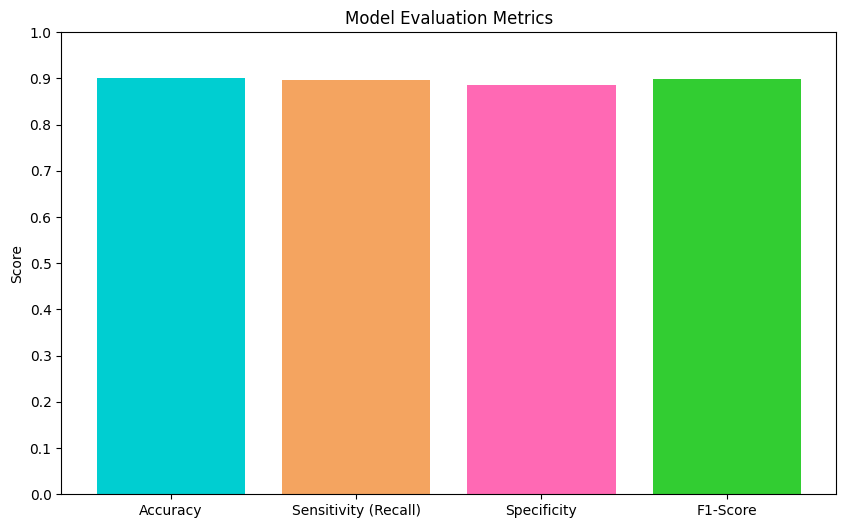

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Accuracy
accuracy = accuracy_score(true_labels, val_predicted_ids)

# Sensitivity/Recall (same as recall_score)
sensitivity = recall_score(true_labels, val_predicted_ids, average='macro')

# Specificity: Not available in sklearn, but it can be calculated as follows:
# Specificity = TN / (TN + FP)
conf_matrix = confusion_matrix(true_labels, val_predicted_ids)
tn = np.diag(conf_matrix).sum() - conf_matrix.sum(axis=1)
fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
specificity = np.mean(tn / (tn + fp))

# F1-Score
f1 = f1_score(true_labels, val_predicted_ids, average='macro')

# Classification Report (includes precision, recall, f1-score for each class)
class_report = classification_report(true_labels, val_predicted_ids, target_names=class_names, digits=4)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", class_report)

# Plot the metrics

# Dictionary to hold the metrics
metrics = {
    "Accuracy": accuracy,
    "Sensitivity (Recall)": sensitivity,
    "Specificity": specificity,
    "F1-Score": f1
}

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['darkturquoise', 'sandybrown', 'hotpink', 'limegreen'])
plt.title("Model Evaluation Metrics")
plt.ylim([0, 1])  # Metrics are between 0 and 1
plt.yticks(np.arange(0, 1.1, 0.1))  # Change Y-axis increments to 0.1
plt.ylabel("Score")
plt.show()